In [1]:
%%js
MathJax.Hub.Config({
  TeX: { 
    equationNumbers: { autoNumber: "AMS" } 
    }
});

<IPython.core.display.Javascript object>

# Моделирование

In [2]:
from pylab import *
rcParams['figure.figsize'] = [7, 6]
rcParams['axes.labelsize'] = 20
from math import pi
from IPython.display import display, Math,Latex,HTML
import pandas as pd
import time
from matplotlib import animation
%load_ext skip

$\renewcommand{\phi}{\varphi}$
Для моделирования случайной поверхности $\Sigma(\vec{r},t)$ используется ее представление в виде суперпозиции плоских волн (гармоник) с различными частотами $\omega_n$ и случайными фазами $\Psi_{nm}$, бегущих под разными азимутальными углами $\phi_m$:
$$\begin{equation*}
    \Sigma(\vec{r},t)=\sum\limits_{n=1}^N\sum_{m=1}^M A_n
    cos(\omega_nt+\vec{k_n}\vec{r}+\Psi_{nm})\cdot\Phi_{nm}
    (\omega_n,\phi_m)
    \label{eq:1}
\end{equation*}$$
Далее будут приведены основные соотношения, необходимые для этого уравнения

In [3]:
def find_decision(omega):
    P = 9.8*1000.0/0.074;
    Q = -1000.0*omega**2/0.074;
    x1= -Q/2.0 + sqrt( (Q/2)**2 + (P/3)**3 )
    x2= -Q/2.0 - sqrt( (Q/2)**2 + (P/3)**3 )
    k=x1**(1/3)-(-x2)**(1/3)
    return k

def det(k): 
#    Функция возвращает детерминант при переходе от частоты к 
#волновым числам по полному дисперсионному
    det=(9.8+3*k**2*0.074/1000)/(2*sqrt(9.8*k+k**3*0.074/1000) )
    return det

In [4]:
global g
g=9.81
def k_max(omega_max):
    k_max=omega_max**2/g
    return k_max

def omega_k(k): # Пересчет волнового числа в частоту по полному дисперсионному
    omega_k=(g*k+0.074*k**3/1000)**(1/2) #Сложное дисперсионное
    return omega_k  

def full_spectrum(k,x=20170, long_calculate=True):
    def JONSWAP(k):
        if k<=k_m:
            sigma=0.07
        else:
            sigma=0.09
        Sw=(
            Alpha(x)/2*k**(-3)*exp(-1.25*(k_m/k)**2 )*
            Gamma(x)**(exp(- ( sqrt(k/k_m)-1)**2 / (2*sigma**2) ))
           )
        return Sw

    def Gamma(x):
        if x>=20170:
            return 1
        gamma=(
               +5.253660929
               +0.000107622*x
               -0.03778776*sqrt(x)
               -162.9834653/sqrt(x)
               +253251.456472*x**(-3/2)
              )
        return gamma

    def Alpha(x):
        if x>=20170:
            return 0.0081
        alpha=array([],dtype='float64')
        alpha=[( 
               +0.0311937
               -0.00232774*log(x)
               -8367.8678786/x**2
               +4.5114599e+300*exp(-x)*1e+300*1e+17
    #            +4.5114599e+17*exp(-x)
              )]
        return alpha[0]

    def Omega(x): #Вычисление безразмерной частоты по безразмерному разгону
        if x>=20170:
            return 0.835
        omega_tilde=(0.61826357843576103 
                     + 3.52883010586243843e-06*x
                     - 0.00197508032233982112*sqrt(x)
                     + 62.5540113059129759/sqrt(x)
                     - 290.214120684236224/x
        )
        return omega_tilde

    def spectrum1(k):


        omega0=omega_k(limit_k[0])
        beta0= JONSWAP(limit_k[0])*omega0**4/det(limit_k[0])

        omega0=omega_k(k)

        return beta0/omega0**4*det(k)

    def spectrum2(k):


        omega0=omega_k(limit_k[1])
        beta0= spectrum1(limit_k[1])*omega0**5/det(limit_k[1])

        omega0=omega_k(k)

        return beta0/omega0**5*det(k)

    def spectrum3(k):


        omega0=omega_k(limit_k[2])
        beta0= spectrum2(limit_k[2])*omega0**2.7/det(limit_k[2])

        omega0=omega_k(k)

        return beta0/omega0**2.7*det(k)

    def spectrum4(k):


        omega0=omega_k(limit_k[3])
        beta0= spectrum3(limit_k[3])*omega0**5/det(limit_k[3])

        omega0=omega_k(k)

        return beta0*det(k)/omega0**5
    
#     def spectrum(k):
#         omega0=[omega_k(limit_k[i]) for i in range(4)]
#         p=[4,5,2.7,5]
#         S=[0,0,0,0]
#         S[0]=lambda a: JONSWAP(limit_k[0]) * (omega0[0]/omega_k(a))**p[0] * det(a)/det(limit_k[0])
#         S[1]=lambda a: S[0](limit_k[1])    * (omega0[1]/omega_k(a))**p[1] * det(a)/det(limit_k[1])
#         S[2]=lambda a: S[1](limit_k[2])    * (omega0[2]/omega_k(a))**p[2] * det(a)/det(limit_k[2])
#         S[3]=lambda a: S[2](limit_k[3])    * (omega0[3]/omega_k(a))**p[3] * det(a)/det(limit_k[3])
#         spectrum=zeros((len(k),4))
#         for j in range(len(k)):
#             for i in range(4):
#                 spectrum[j][i]=S[i](k[j])
#         return spectrum
    
    gamma,alpha,omega_m=Gamma(x),Alpha(x),Omega(x)
    
    try:
        full_spectrum=zeros(len(k))
    except:
        full_spectrum=[0]
        k=[k]
    if long_calculate==False:
        k=logspace(log10(k[0]),log10(k[-1]),1000)
        
    omega=omega_m*g/U10
    global k_m
    k_m=k_max(omega)
    limit_1= 1.2   #{ НАЧИНАЕТСЯ  - 1/(W**4) }
    limit_2=(
             +0.371347584096022408 
             + 0.290241610467870486*U10
             + 0.290178032985796564/U10
            )
    limit_3= 270.0 #{ НАЧИНАЕТСЯ 1/W**2.7 }
    limit_4= 1020.0 #{ НАЧИНАЕТСЯ 1/W*5 }

    limit_k=np.zeros(4)
    limit_k[0]=find_decision(limit_1*omega)
    limit_k[1]=find_decision(limit_2*omega)
    limit_k[2]=limit_3
    limit_k[3]=limit_4

    for i in range(len(k)):
        if k[i] <= limit_k[0]:
            full_spectrum[i] =  JONSWAP(k[i])
        elif k[i] <= limit_k[1]:
            full_spectrum[i] = spectrum1(k[i])
        elif k[i] <= limit_k[2]:
            full_spectrum[i] = spectrum2(k[i])
        elif k[i] <= limit_k[3]:
            full_spectrum[i] = spectrum3(k[i])
        else:
            full_spectrum[i] = spectrum4(k[i])

#     S=spectrum(k)
#     for i in range(len(k)):
#         if k[i] <= limit_k[0]:
#             full_spectrum[i] =  JONSWAP(k[i])
#         elif k[i] <= limit_k[1]:
#             full_spectrum[i] = S[i][0]
#         elif k[i] <= limit_k[2]:
#             full_spectrum[i] = S[i][1]
#         elif k[i] <= limit_k[3]:
#             full_spectrum[i] = S[i][2]
#         else:
#             full_spectrum[i] = S[i][3]

    return full_spectrum

Время выполнения --- 18.205605506896973 c


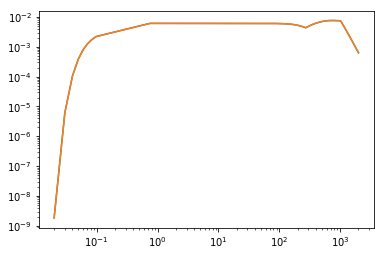

In [5]:
U10=10
x=20170
name='SEAWVS_1.dat'
data=pd.read_csv(name,sep='\s+')
KT=array(data['KT'])
OUR=array(data['OUR'])
loglog(KT,OUR)
k=linspace(KT[0],KT[-1],len(KT))
# k=logspace(log10(k[0]),log10(k[-1]),10000)
start_time = time.time()
S=full_spectrum(k,x=20170)
print("Время выполнения --- %s c" % (time.time() - start_time))
loglog(k,k**3*S)

## Угловое распределение
Угловое распределение $\Phi_{\omega}$ описывается следующей формулой:
$$\Phi_{\omega}=A\cdot\frac{2}{\exp(2B\phi)+\exp(-2B\phi)}=\frac{A}{\cosh(2B\phi)},\, -\pi\leq\phi\leq\pi$$
Где $B=10^b$, а b описывается следующей формулой:
$$b=-0.28+0.65\exp\left\{-0.75\log(\frac{k}{k_m})\right\}+0.01\exp\left\{0.2+0.7\lg(\frac{k}{k_m})\right\}$$

<IPython.core.display.Math object>

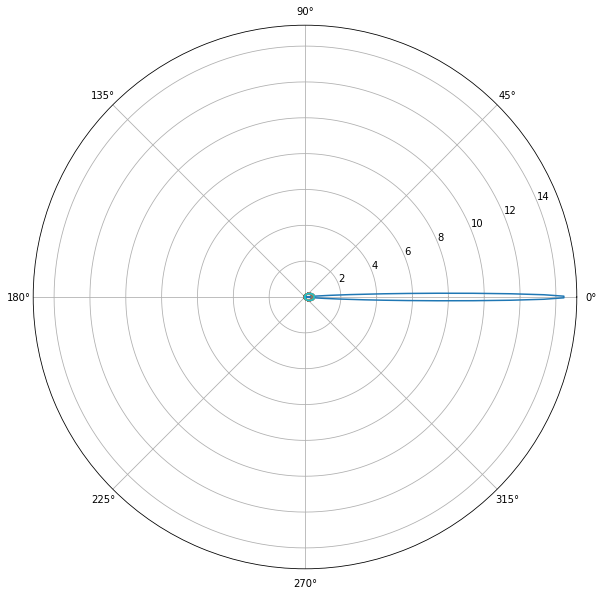

In [6]:
def B(k):
    def b(k):
        b=(
            -0.28+0.65*exp(-0.75*log(k/k_m))
            +0.01*exp(-0.2+0.7*log10(k/k_m))  
          )          
        return b
    B=10**b(k)
    return B

def Normalization(B):
    Normalization=B/arctan(sinh(2*pi*B))
    return Normalization

def Phi(k,phi):
    try:
        Phi=zeros((len(k),len(phi)))
        for i in range(len(k)):
            B0=B(k[i])
            A0=Normalization(B0)
            Phi[i]=A0/cosh(2*B0*phi)
    except:
        B0=B(k)
        A0=Normalization(B0)
        Phi=A0/cosh(2*B0*phi)
    return Phi

x=linspace(-pi,pi,1000)
figure(figsize=(10,10))
for i in linspace(KT[0],KT[-1],100):
    y=Phi(i,x)
    polar(x,y)

integral=trapz(y,x)

display(Math(
 r'Интеграл\,функции\,распределения:\\'
 +'\displaystyle\int\limits_{-\pi}^{\pi}'
 +'\Phi_{\omega}(\omega,\phi)d\phi'
 +'={0} \simeq  {1}'.format(integral,round(integral,3)) 
)
       )

Для наглядности ниже будет анимация:

# Для проверки

Все равно придётся считать

 
 При увеличении числа гармоник происходит
улучшение качества моделируемой поверхности, но возрастает время
счета. Поэтому, как и в случае с угловым распределением, здесь также
было выбрано компромиссное решение. Критерием была выбрана 
    близость корреляционных функций высот $ K_{\sum} (\rho)$ и наклонов вычисленных по исходному спектру $S_{\sum}(\omega)$ и по реализации поверхности $\Sigma (\vec r, t)$:
 
 $$K_{\sum}(\rho)=\int\limits_{(k)}S_{\sum}(k)\cos(k\rho)dk$$
 
 $$K_{\sum}^M(\rho)=\sum\limits_{n=1}^N \frac{A^2_n}{2}\cos(k\rho)$$
  
 $$K_{\sum\theta}(\rho)=\int\limits_{(k)}k^2S_{\sum}(k)\cos(k\rho)dk$$
   
  $$K_{\sum\theta}^M(\rho)=\sum\limits_{n=1}^N \frac{A^2_n k^2}{2}\cos(k\rho)$$

0.0
2000.982


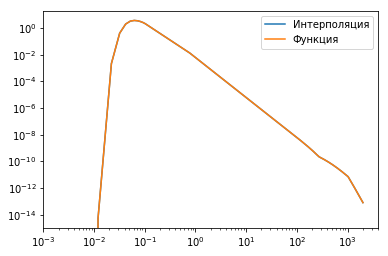

In [7]:
from scipy import interpolate
k=arange(KT[0]/10,KT[-1]+1,0.01)
S=full_spectrum(k)
full_spectrum=interpolate.interp1d(k,S)
loglog(k,full_spectrum(k),label='Интерполяция')
loglog(k,S,label='Функция')
print(norm(S-full_spectrum(k)))
print(k[-1])
legend()
k_edge=111.8-17.937*U10+3.095*U10**2+1.2656*U10**2*log(U10)+0.3141*U10*(2.5)



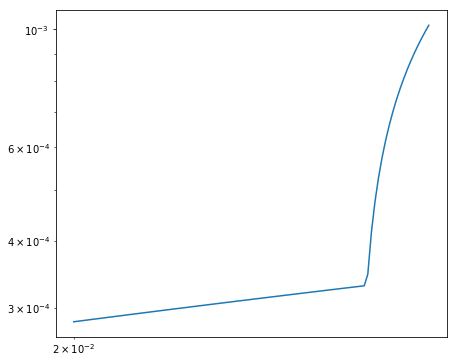

In [23]:
def angle(k,phi):
    angle=sqrt( 2*pi/100 * Phi(k,phi) )
    return angle

def amplitude(k,N):
    # k-- выбранный диапазон волновых чисел
    # N-- количество моделируемых гармоник
    N+=1
    k=logspace(log10(KT[0]),log10(KT[-1]),N)
    S=full_spectrum(k)
    dk=zeros(N)
    dS=zeros(N)
#     dk[0]=(k[1]-k[0])
    for i in range(1,N):
        dk[i]=(k[i]-k[i-1])
        dS[i]=S[i]
    amplitude=sqrt(2*dk * dS)
    return amplitude[1:]
# def amplitude_new(k,N):
#     # k-- выбранный диапазон волновых чисел
#     # N-- количество моделируемых гармоник
#     N+=1
#     k=logspace(log10(k[0]),log10(k[-1]),N)
#     dk=zeros(N)
# #     dk[0]=(k[1]-k[0])
#     for i in range(1,N):
#         dk[i]=(k[i]-k[i-1])
#         dS[i]=S[i]
#     amplitude=sqrt(2*dk * dS)
#     return amplitude[1:]
N=10000
k=logspace(log10(KT[0]),log10(KT[-1]),N)
A=amplitude(k,N)
loglog(k[0:100],A[0:100])
# plot(amplitude(k,N))

Встала задача нахождения интеграла аналитически. Для этого изначально ещё нужно выбрать оптимальное распеределение волновых чисел.

0.33986334150330166 0.3400591033071311


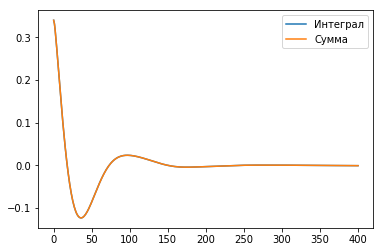

In [9]:
# print avada kedavra
from scipy.integrate import simps
from numpy.linalg import norm
U10=10

def correlation_height(k,rho):
    S=full_spectrum(k)
    integral=zeros(len(rho))
    for i in range(len(rho)):
        integral[i]=trapz(S*cos(k*rho[i]),k)
    return integral

def correlation_height_sum(k,rho,N=1000):
    f=0
    A=amplitude(k,N)
    k=logspace(log10(KT[0]),log10(KT[-1]),N)
    f=zeros(len(rho))
    for j in range(len(rho)):
            f[j]=sum( A**2/2*cos(k*rho[j]) )
    return f

    
k=logspace(log10(KT[0]),log10(KT[-1]),10000)
rho=linspace(0,400,400)
y=zeros(len(rho))
N=1000
y=correlation_height_sum(k,rho, N=10000)
y1=correlation_height(k,rho)
print(y[0],y1[0])
plot(rho,y1,label='Интеграл')
plot(rho,y,label='Сумма')
legend()



541.1976693693264
0.05470614653323365 0.05483791542601804


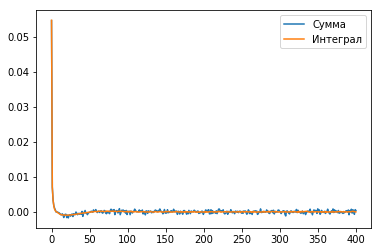

In [10]:
# print avada kedavra
k_edge=111.8-17.937*U10+3.095*U10**2+1.2656*U10**2*log(U10)+0.3141*U10*(2.5)
def correlation_angles(k,rho):
    integral=zeros(len(rho))
    S=k**2*full_spectrum(k)
    y=lambda k,rho: S*cos(k*rho)
    for i in range(len(rho)):
        integral[i]=trapz(y(k,rho[i]),x=k)
    return integral
    
def correlation_angles_sum(k,rho,N=10000):
    f=0
    A=amplitude(k,N)
    k=logspace(log10(KT[0]),log10(KT[-1]),N)
    f=zeros(len(rho))
    for j in range(len(rho)):
            f[j]=sum( k**2*A**2/2*cos(k*rho[j]) )
    return f
print(k_edge)
k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
rho=linspace(0,400,400)
y=zeros(len(rho))
y=correlation_angles_sum(k,rho,N=6400)
y1=correlation_angles(k,rho)
plot(rho,y,label='Сумма')
plot(rho,y1,label='Интеграл')
legend()
print(y[0],y1[0])


In [11]:
def find_garmonics(k,rho):
    N=100
    k=logspace(log10(KT[0]),log10(KT[-1]),10000)
    S=correlation_height_sum(k,rho,N)
    I=correlation_height(k,rho)
    while abs(norm(S-I))>0.01:
        N*=2
        S=correlation_height_sum(k,rho,N)
    print('Количество гармоник для высот N=',N)
    
    k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
    S=correlation_angles_sum(k,rho,N)
    I=correlation_angles(k,rho)
    while abs(norm(S-I))>0.01:
        N*=2
        S=correlation_angles_sum(k,rho,N)
    print('Количество гармоник для наклонов N=',N)
    return N
k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
rho=linspace(0,400,400)
find_garmonics(k,rho)

Количество гармоник для высот N= 3200
Количество гармоник для наклонов N= 6400


6400

Время выполнения --- 0.011991262435913086 c
Дисперсия = 0.4757744314974604
[0.34005919]


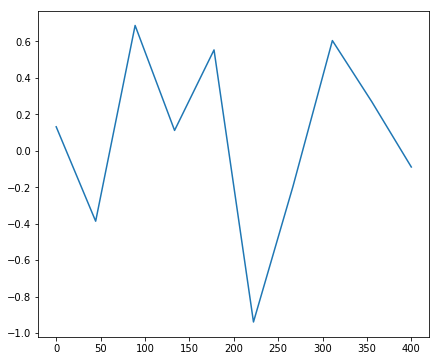

In [51]:
from numpy import random
def model(k,phi,N):
    U10=10
    rho=linspace(0,400,400)
    A=amplitude(k,N)
    F=angle(k,phi)
    psi=array([
    [ random.uniform(0,2*pi) for j in range(100)] 
      for i in range(N)              ]) 
    
    def water(r,phi,t=0):
        model=0
        for n in range(N):
            for m in range(100):
                model+=A[n]*cos(
                    k[n]*(r[0]*cos(phi[m])+r[1]*sin(phi[m]))+psi[n][m]
                )*F[n][m]
        return model
    
    return water

k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
rho=linspace(0,400,400)
# N=find_garmonics(k,rho)
N=6000
k=logspace(log10(KT[0]),log10(KT[-1]),N)
phi=linspace(-pi,pi,100)

sigma=model(k,phi,N)
x=linspace(0,400,10)
y=linspace(0,400,10)
water=sigma([x,y],phi)
start_time = time.time()
plot(x,water)
print("Время выполнения --- %s c" % (time.time() - start_time))

dispersion=std(water)
# mn=mean(sigma(x))
print('Дисперсия =',dispersion)
# print('Среднее=',mn)
print(correlation_height(k,[0]))

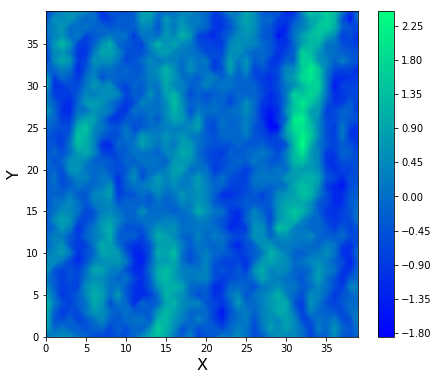

In [53]:
# %matplotlib inline
x=linspace(0,400,40)
y=linspace(0,400,40)
rcParams['figure.figsize'] = [7, 6]
rcParams['axes.labelsize'] = 20
x, y = np.meshgrid(x, y)
z=sigma([x,y],phi)
contourf(z,100,cmap=cm.winter)
colorbar()
ylabel(r'Y',fontsize=16)
xlabel(r'X',fontsize=16)
savefig('water.png',pdi=1500)
show()